## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
def learning(model, opt, loss_func, n_epochs, train_loader, test_loader):
  print('Info:')
  torchsummary.summary(model, (28*28,))
  print('Train: ')
  loss_train_array, loss_test_array = [], []
  accuracy_test_array, accuracy_train_array = [], []

  for epoch in range(n_epochs):
    accuracy_train = accuracy_test = mean_loss_test = mean_loss_train = 0

    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_pred = model.forward(x_batch)

      loss = loss_func(y_pred, y_batch)

      opt.zero_grad()

      loss.backward()

      opt.step()

      accuracy_train += (y_batch == y_pred.argmax(axis=1)).float().sum()
      mean_loss_train += loss
    accuracy_train /= len(fmnist_dataset_train)
    mean_loss_train /= len(fmnist_dataset_train)
    accuracy_train_array.append(accuracy_train)
    loss_train_array.append(mean_loss_train)

    for x_batch, y_batch in test_loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_pred = model.forward(x_batch)
      accuracy_test += (y_batch == y_pred.argmax(axis=1)).float().sum()
      mean_loss_test += loss_func(y_pred, y_batch)
    accuracy_test /= len(fmnist_dataset_test)
    mean_loss_test /= len(fmnist_dataset_test)
    accuracy_test_array.append(accuracy_test)
    loss_test_array.append(mean_loss_test)

    print(f'epoch = {epoch+1}/{n_epochs}, acc_train = {accuracy_train:.4f}, acc_test = {accuracy_test:.4f}, loss_train = {mean_loss_train:.4f}, loss_test = {mean_loss_test:.4f}')

  print('Plots:')
  plt.figure(figsize = (12, 6))

  plt.subplot(121)
  plt.title('Accuracy')
  plt.plot(accuracy_test_array, label='test')
  plt.plot(accuracy_train_array, label='train')
  plt.hlines(0.885, 0, n_epochs, label='acc=0.885')
  plt.legend()

  plt.subplot(122)
  plt.title('Loss')
  plt.plot(loss_test_array, label='test')
  plt.plot(loss_train_array, label='train')
  plt.legend()

  plt.show()

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 700),
            nn.Sigmoid(),
            nn.Linear(700, 100),
            nn.Sigmoid(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

Your experiments come here:

Info:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
           Sigmoid-3                  [-1, 700]               0
            Linear-4                  [-1, 100]          70,100
           Sigmoid-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 620,610
Trainable params: 620,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.37
Estimated Total Size (MB): 2.39
----------------------------------------------------------------
Train: 
epoch = 1/20, acc_train = 0.7435, acc_test = 0.8270, loss_train = 0.0059, loss_test = 0.0019

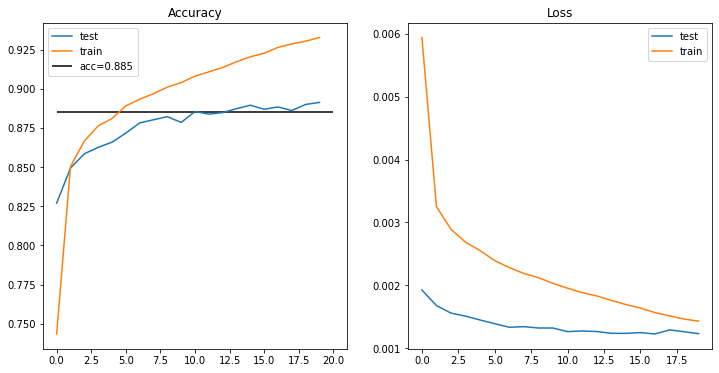

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.model.parameters())
loss_func = nn.CrossEntropyLoss()

learning(model=model,
         opt=opt,
         loss_func=loss_func,
         n_epochs=20,
         train_loader=train_loader,
         test_loader=test_loader)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [10]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

Info:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 100]          20,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated Total Size (MB): 0.69
----------------------------------------------------------------
Train: 
epoch = 1/50, acc_train = 0.7967, acc_test = 0.8277, loss_train = 0.0045, loss_test = 0.0019

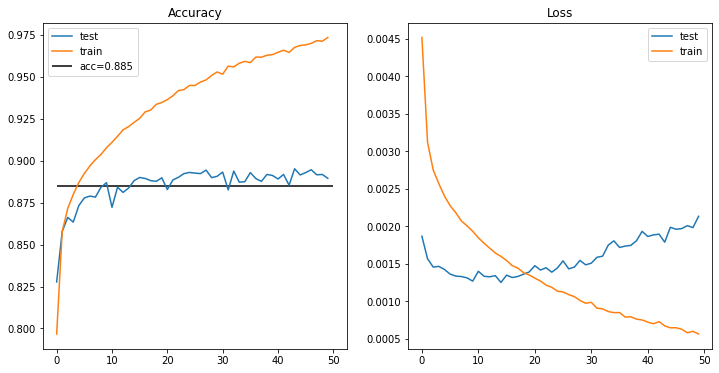

In [11]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.model.parameters())
loss_func = nn.CrossEntropyLoss()

learning(model=model,
         opt=opt,
         loss_func=loss_func,
         n_epochs=50,
         train_loader=train_loader,
         test_loader=test_loader)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [12]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 200),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

Info:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
           Dropout-3                  [-1, 200]               0
              ReLU-4                  [-1, 200]               0
            Linear-5                  [-1, 100]          20,100
           Dropout-6                  [-1, 100]               0
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
        LogSoftmax-9                   [-1, 10]               0
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated Total Size (MB): 0.70
-------------------------------------

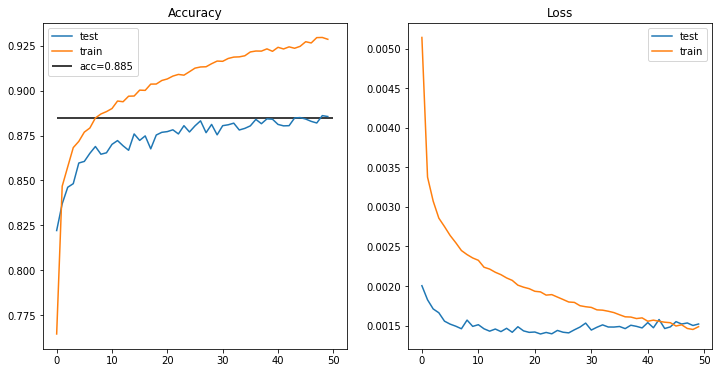

In [13]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.model.parameters())
loss_func = nn.CrossEntropyLoss()

learning(model=model,
         opt=opt,
         loss_func=loss_func,
         n_epochs=50,
         train_loader=train_loader,
         test_loader=test_loader)

### Conclusions:
A neural network with a small number of layers has good quality if used a few (about 20) epochs and if used sigmoid as an activation function (adds more nonlinearity). If the epochs become around 50 and the activation function becomes ReLU, then the model overfitting, but this is corrected by adding Dropout layers.

Conclusion: it is worth initially creating an adequate network architecture and choosing the number of epochs, but even if this is not obvious, regularization can help. It is also worth noting that you can simply stop training before overfitting, if the necessary quality is achieved